In [1]:
import torch
import os
import random
import numpy as np
import pytorch_lightning as pl

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from dataset.utils import process_classification_dataset

config = {
        'dataset': 'facebook_ct1', # 'infectious_ct1', #
        'hidden_size': 32,
        'rnn_layers': 8,
        'readout_layers': 3,
        'cell_type': 'lstm',
        'dim_red': 64,
        'add_self_loops': False,
        'verbose': True,
        'cat_states_layers': True,
        'weight_decay': 1e-3,
        'step_size': 30,
        'gamma': 0.5
        }

# Select one GPU if more are available
os.environ["CUDA_VISIBLE_DEVICES"]='0'

seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
pl.seed_everything(seed)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
Seed set to 42


In [2]:
# Fix cuda memory issue
dataset, states, node_states = process_classification_dataset(config, "DynCRNN", device)

100%|██████████| 995/995 [20:58<00:00,  1.26s/it]


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

inputs, test_inputs, labels, test_labels = train_test_split(states.inputs[:,-1,:], dataset.targets, test_size=0.2, random_state=seed)

# Create the classifier
classifier = LogisticRegression(max_iter=5000, random_state=seed)

# Train the classifier
classifier.fit(inputs, labels)

# Test the classifier
y_pred = classifier.predict(test_inputs)

accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9547738693467337


# PCA

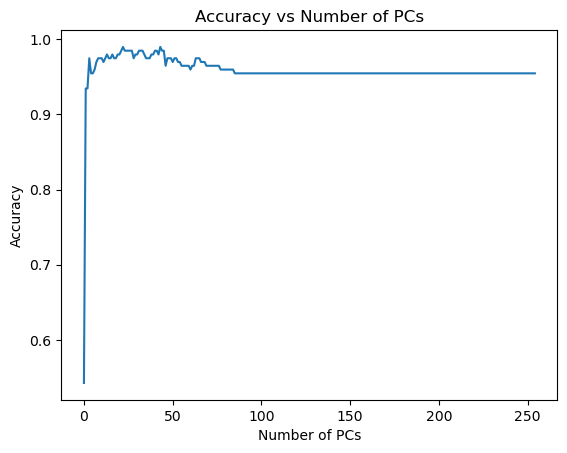

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

train_X, val_X, train_y, val_y = train_test_split(states.inputs, states.targets, test_size=0.2, random_state=seed)

accs = []
for dim_red in range(1, train_X.shape[-1]):
    pca = PCA(n_components=dim_red)
    train_X_red = pca.fit_transform(train_X[:,-1,:])
    val_X_red = pca.transform(val_X[:,-1,:])

    classifier = LogisticRegression(max_iter=5000, random_state=seed)
    classifier.fit(train_X_red, train_y)
    y_pred = classifier.predict(val_X_red)
    accs.append(accuracy_score(val_y, y_pred))

accs = np.array(accs)

plt.plot(accs)
plt.xlabel('Number of PCs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of PCs')
plt.show()

Check which PC contains more information

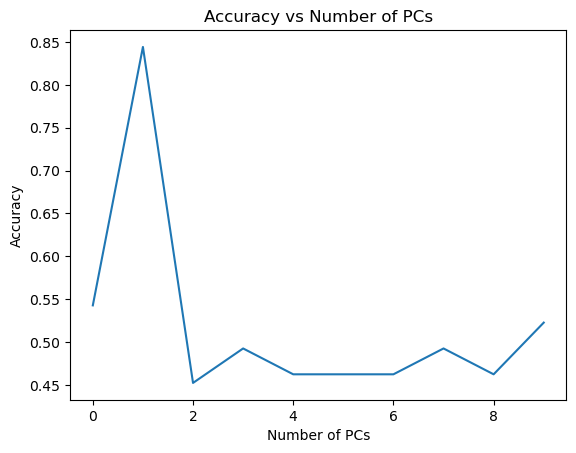

In [13]:
accs = []

pca2 = PCA(n_components=10)
train_X_red2 = pca2.fit_transform(train_X[:,-1,:])
val_X_red2 = pca2.transform(val_X[:,-1,:])

for i in range(0, train_X_red2.shape[-1]):
    x = train_X_red2[:,i]
    x = x[:, np.newaxis]
    classifier2 = LogisticRegression(max_iter=5000, random_state=seed)
    classifier2.fit(x, train_y)
    x = val_X_red2[:,i]
    x = x[:, np.newaxis]
    y_pred = classifier2.predict(x)
    accs.append(accuracy_score(val_y, y_pred))

accs = np.array(accs)

plt.plot(accs)
plt.xlabel('Number of PCs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of PCs')
plt.show()

The second one!

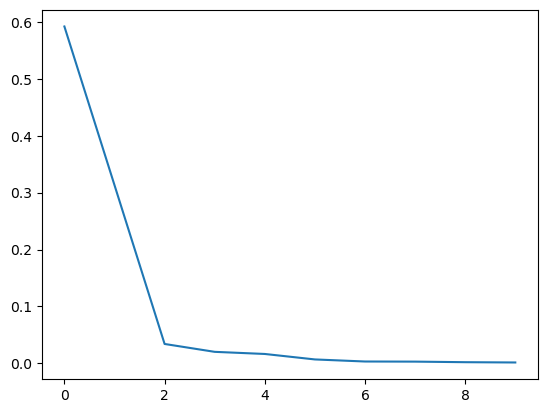

In [14]:
plt.plot(pca2.explained_variance_ratio_)